### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import copy
import datetime as dt
import math
import timm
from math import ceil
from matplotlib import colormaps
import PIL
import random
from IPython.display import display, clear_output
import kornia

try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset


# Torch
import torch
from torch.autograd import Variable
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.models as models
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")
    
    
from utils.models.EfficientNet import EfficientNet
from utils.models.TinyVGG import TinyVGG
from utils.models.ResNet import ResNet
from utils.models.VGG16 import VGG16
from utils.models.EfficientNetb1 import EfficientNet_b1
from utils.pipelines.image_transformation import image_transformer 

# Scikit learn accuracy score
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

torchvision.disable_beta_transforms_warning()

From https://github.com/RasKrebs/aml_itu
 * branch            main       -> FETCH_HEAD
Already up to date.
/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu
MPS device found.


/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:63: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you m

In [2]:
# Load config
config = load_config(eval(os.environ["COLAB"]))

### Get data

In [3]:
def prepare_data(img_size='S', shuffle=False, return_just_test_data = False):
    # Target Transformations (Removing the c from the target)
    target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))
   
    # Predefined image sizes
    img_sizes = {
        'S': (48, 64),
        'M': (93, 124),
        'L':(168, 224),
        'L_SQUARED':(224, 224),
    }
    
    # Image augmentations - apply default if none is specified
    image_augmentations = v2.Compose([T.Resize(img_sizes[img_size], antialias=True),
                                      T.RandomHorizontalFlip(p=.0),
                                      v2.ToDtype(torch.float32, scale=True)])
    
    # Creating the dataset
    test_data = StateFarmDataset(config, 
                            split='test', 
                            transform=image_augmentations if not return_just_test_data else None, 
                            target_transform=target_transform)
    
    if return_just_test_data:
        return test_data
    
    # Creating the dataloader
    test_loader = DataLoader(test_data, 
                            batch_size=32, 
                            shuffle=shuffle)
    
    return test_loader, test_data

#### Load Models

In [4]:
# Tiny VGG model
# Path and directory files
TinyVGG_path = os.path.join(config['outputs']['path'], 'TinyVGG_500k')
TinyVGG_file = 'TinyVGG_500k_final.pt'

# initalize model
tinyvgg = TinyVGG()

# Load parameters from last model
tinyvgg.load_state_dict(torch.load(os.path.join(TinyVGG_path, TinyVGG_file)))
tinyvgg = tinyvgg.eval()

In [5]:
# EfficientNet model
# Load model
efficient = EfficientNet()

# Load parameters from last model
efficient.load_state_dict(torch.load(os.path.join(config['outputs']['path'], 'EfficientNet_after_CV', 'EfficientNet_final.pt'), map_location=torch.device('cpu')))
efficient = efficient.eval()

In [6]:
# EfficientNet b1 model - pretrained 
# Load model
efficientb1 = EfficientNet_b1('outputs/EfficientNet/efficientnet_b1_94.pt')
efficientvb1 = efficientb1.eval()

In [8]:
# Resnet model - pretrained 
# Load model
resnet = ResNet('outputs/ResNet/ResNet_v2_20231230_143836_epoch_14.pt')
resnet = resnet.eval()

In [10]:
# vgg16 model - pretrained 
# Load model
vgg16 = VGG16('outputs/VGG16/VGG16_v3_20231229_183229_epoch_10.pt')
vgg16 = vgg16.eval()

## Run Test

#### Vanilla Test

In [11]:
def test(model, 
         device,
         img_size='L_SQUARED'):
    """Test loop"""
    print('Starting test loop')
    # Prepare data
    test_loader, test_data = prepare_data(img_size=img_size)

    # Setup test accuracy
    test_acc = 0
    
    # Setup lists for storing images, classes and predictions
    images = []
    classes = []
    predictions = []
    predictions_argmax = []
    
    # Set model to eval
    model = model.eval()
    
    # Sent model to device
    model = model.to(device)
    
    print('Starting loop through test data...')
    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(test_loader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            images.append(imgs), classes.append(labels)
            
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass
            prediction = model(imgs)
            predictions.append(prediction)
            predictions_argmax.append(prediction.argmax(1))

            # Update test accuracy
            test_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return test accuracy
    print(f'Test Done. Accuracy {test_acc / len(test_loader)}')
    return images, classes, predictions, predictions_argmax

In [25]:
print('TinyVGG Test')
test_prediction_tiny = test(tinyvgg, device, img_size='S')

Starting test loop
Starting loop through test data...
Test Done. Accuracy 0.805065639623224


In [26]:
print('EfficientNet from scratch test')
test_prediction_efficient = test(efficient, device, img_size='L_SQUARED')

EfficientNet from scratch test
Starting test loop
Starting loop through test data...
Test Done. Accuracy 0.8056506849315068


In [27]:
print('EfficientNetb1 pretrained test')
test_prediction_efficientb1 = test(efficientb1, device, img_size='L_SQUARED')

EfficientNetb1 pretrained test
Starting test loop
Starting loop through test data...
Test Done. Accuracy 0.930636415742848


In [12]:
print('ResNet pretrained test')
test_prediction_resnet = test(resnet, device, img_size='L_SQUARED')

ResNet pretrained test
Starting test loop
Starting loop through test data...
Test Done. Accuracy 0.20271118722651918


In [30]:
print('VGG16 pretrained test')
test_prediction_efficient = test(vgg16, device, img_size='L_SQUARED')

VGG16 pretrained test
Starting test loop
Starting loop through test data...
Test Done. Accuracy 0.8948915527291494


## Simulated real life: Sequential Predictions

In [13]:
test_data = prepare_data(return_just_test_data=True)

# Sorting test data
test_data.metadata = test_data.metadata.sort_values(by=['subject', 'target','img'])
test_data.img_labels = test_data.metadata[['img','classname', 'img_path']]

In [14]:
def predict_image(image_tensor, model, device, img_size='L_SQUARED'):
    # Transform image
    frame = image_transformer(image_tensor, size=img_size)
    
    # Batch image
    frame = frame.unsqueeze(0)
    
    # Sent to device
    frame.to(device)
    
    # Predict
    model = model.eval()
    with torch.no_grad():
        # Get start time to compute inference time
        time_start = time.time()
        
        # Predict
        prediction = model(frame.to(device))
        
        # Get inference time
        time_final = time.time() - time_start
    
    return prediction, time_final
    

In [15]:
def sequential_image_predictor(model, test_data, image_size, weighted_prediction):
    # Setup lists for storing images, classes and predictions
    classes = []
    predictions_argmax = []
    weighted_predictions = []
    inference_times = []
    
    # Sent model to device
    model = model.to(device)
    
    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(test_data):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            classes.append(labels.cpu().numpy())
            
            # Predict
            prediction, inference_time = predict_image(imgs, model, device, img_size=image_size)
            weighted_predictions.append(weighted_prediction(prediction))
            predictions_argmax.append(prediction.argmax(1).cpu().numpy())
            inference_times.append(inference_time)
            
            # Print progress
            if i % 1000 == 0:
                print(f'Predicted {i} images')
            
    # Return test accuracy
    print(f'Test Done. Predicted {len(test_data)} images, with an average inference time of {np.mean(inference_times)}')
    return classes, predictions_argmax, weighted_predictions, inference_times

In [47]:
def unpack_results(results, weighted_predictor, confusion_matrix_labels = config['dataset']['class_mapping'].values()):
    # Unpack results
    classes, predictions_argmax, weighted_predictions, inference_times = results
    
    # Flatten lists
    try:
        predictions_argmax = np.concatenate(predictions_argmax)
    except:
        pass
    # Mapped predictions
    efficient_mapped = np.array([weighted_predictor.map_labels(i) for i in predictions_argmax])

    # Classes mapped
    classes_mapped = np.array([weighted_predictor.map_labels(i) for i in classes])

    # Print accuracies
    print(f'Average inference time {np.mean(inference_times)}, which is {round(1/np.mean(inference_times))} fps')
    print(f'Accuracy of all predictions {np.mean(classes == predictions_argmax)}')
    print(f'Accuracy of weighted predictor {np.mean(classes[9:] == weighted_predictions[9:])}') # Excl. out of scope predictions
    # Print F1, precision and recall scores
    print(f'F1 score of all predictions {f1_score(classes, predictions_argmax, average="macro")}')
    print(f'Precision score of all predictions {precision_score(classes, predictions_argmax, average="macro")}')
    print(f'Recall score of all predictions {recall_score(classes, predictions_argmax, average="macro")}')
    
    # Make confusion matrix
    cm = confusion_matrix(classes, predictions_argmax)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=confusion_matrix_labels)

    disp.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')

### Sequential Prediction for Models

**TinyVGG**

In [17]:
# Generated weighted predictions object
weighted_predictor = weighted_prediction(config, n=10)

# Run predictions sequentially from sorted data
tiny_results = sequential_image_predictor(tinyvgg, test_data, 'S', weighted_predictor)

Predicted 0 images
Predicted 1000 images
Predicted 2000 images
Predicted 3000 images
Predicted 4000 images
Test Done. Predicted 4670 images, with an average inference time of 0.002148704661546989


Average inference time 0.002148704661546989, which is 465 fps
Accuracy of all predictions 0.8051391862955032
Accuracy of weighted predictor 0.0
F1 score of all predictions 0.7905410295973377
Precision score of all predictions 0.8204950571356726
Recall score of all predictions 0.793583281950953


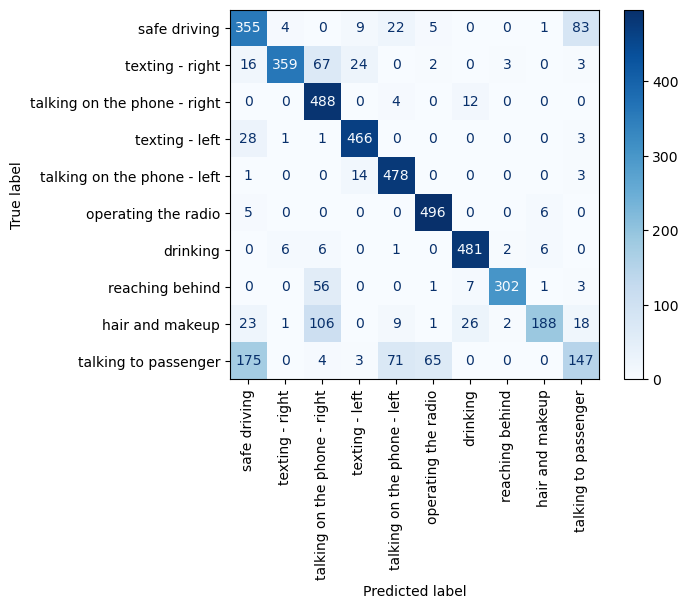

In [18]:
unpack_results(tiny_results, weighted_predictor)

Average inference time 0.002148704661546989, which is 465 fps
Accuracy of all predictions 0.8603854389721627
Accuracy of weighted predictor 0.8251448187084317
F1 score of all predictions 0.8538748925854568
Precision score of all predictions 0.8812768670834853
Recall score of all predictions 0.8537401315967967


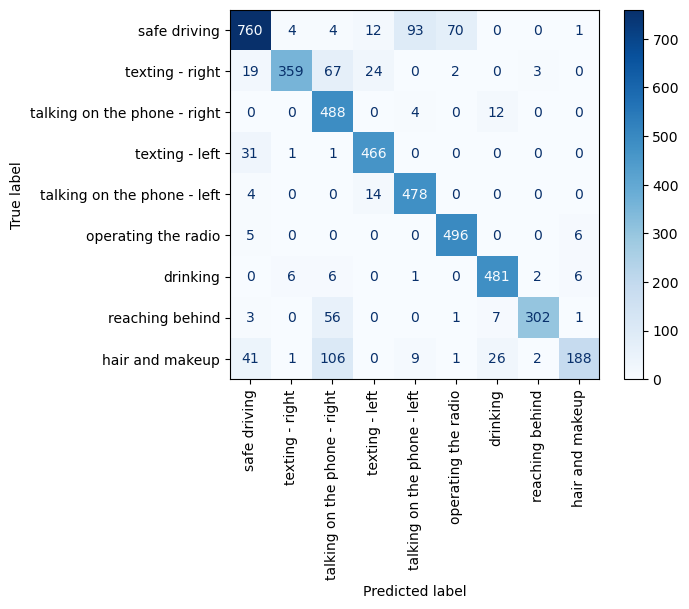

In [57]:
# Testing results if talking to passenger was omitted
y, t, _, _ = tiny_results

y = np.array(y)
t = np.array(t).flatten()

y = np.where(y == 9, 0, y)
t = np.where(t == 9, 0, t)

unpack_results((y, t, tiny_results[2], tiny_results[3]), weighted_predictor, confusion_matrix_labels=list(config['dataset']['class_mapping'].values())[:-1])

**EfficinetNet from Scratch**

In [25]:
# Generated weighted predictions object
weighted_predictor = weighted_prediction(config, n=10)

# Run predictions sequentially from sorted data
efficient_results = sequential_image_predictor(efficient, test_data, 'L_SQUARED', weighted_predictor)

Predicted 0 images
Predicted 1000 images
Predicted 2000 images
Predicted 3000 images
Predicted 4000 images
Test Done. Predicted 4670 images, with an average inference time of 0.018093793295180263


In [26]:
unpack_results(efficient_results, weighted_predictor)

Average inference time 0.018093793295180263, which is 55 fps
Accuracy of all predictions 0.8059957173447537
Accuracy of weighted predictor 0.0
F1 score of all predictions 0.7872872137007733
Precision score of all predictions 0.813972594772391
Recall score of all predictions 0.798244560343244


Average inference time 0.018093793295180263, which is 55 fps
Accuracy of all predictions 0.8698072805139186
Accuracy of weighted predictor 0.8405921476078095
F1 score of all predictions 0.8669568377178144
Precision score of all predictions 0.8949258639007146
Recall score of all predictions 0.876326453656078


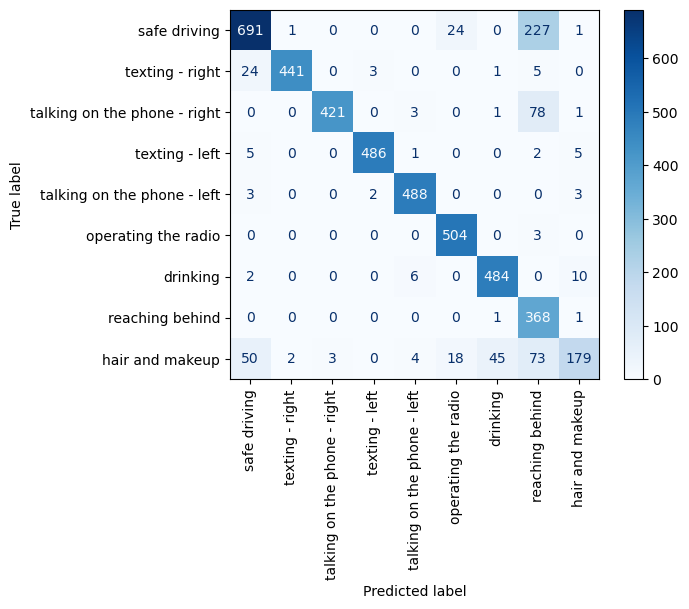

In [56]:
# Testing results if talking to passenger was omitted
y, t, _, _ = efficient_results

y = np.array(y)
t = np.array(t).flatten()

y = np.where(y == 9, 0, y)
t = np.where(t == 9, 0, t)

unpack_results((y, t, efficient_results[2], efficient_results[3]), weighted_predictor, confusion_matrix_labels=list(config['dataset']['class_mapping'].values())[:-1])

**EfficinetNetB1 Pretrained**

In [23]:
# Generated weighted predictions object
weighted_predictor = weighted_prediction(config, n=10)

# Run predictions sequentially from sorted data
efficientb1_results = sequential_image_predictor(efficientb1, test_data, 'L_SQUARED', weighted_predictor)

Predicted 0 images
Predicted 1000 images
Predicted 2000 images
Predicted 3000 images
Predicted 4000 images
Test Done. Predicted 4670 images, with an average inference time of 0.0263411426442083


Average inference time 0.0263411426442083, which is 38 fps
Accuracy of all predictions 0.9306209850107067
Accuracy of weighted predictor 0.0
F1 score of all predictions 0.928762215668737
Precision score of all predictions 0.9293804740884083
Recall score of all predictions 0.9287071142001893


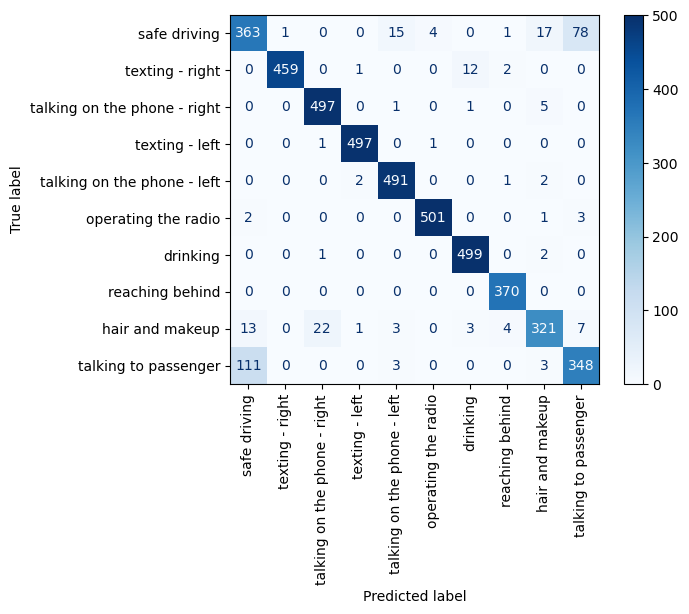

In [24]:
unpack_results(efficientb1_results, weighted_predictor)

Average inference time 0.0263411426442083, which is 38 fps
Accuracy of all predictions 0.9710920770877944
Accuracy of weighted predictor 0.8695558892941428
F1 score of all predictions 0.9698032212109654
Precision score of all predictions 0.9695868097665353
Recall score of all predictions 0.9704716739683664


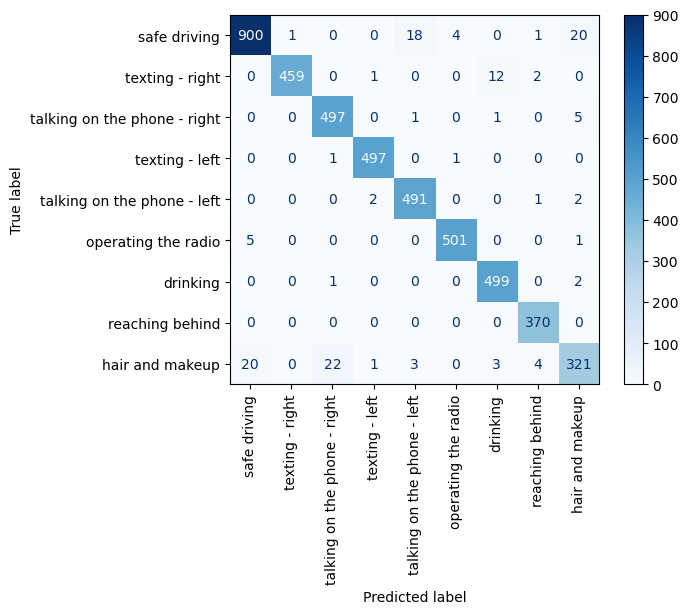

In [54]:
# Testing results if talking to passenger was omitted
y, t, _, _ = efficientb1_results

y = np.array(y)
t = np.array(t).flatten()

y = np.where(y == 9, 0, y)
t = np.where(t == 9, 0, t)

unpack_results((y, t, efficientb1_results[2], efficientb1_results[3]), weighted_predictor, confusion_matrix_labels=list(config['dataset']['class_mapping'].values())[:-1])

**ResNet**

In [19]:
# Generated weighted predictions object
weighted_predictor = weighted_prediction(config, n=10)

# Run predictions sequentially from sorted data
resnet_results = sequential_image_predictor(resnet, test_data, 'L_SQUARED', weighted_predictor)

Predicted 0 images
Predicted 1000 images
Predicted 2000 images
Predicted 3000 images
Predicted 4000 images
Test Done. Predicted 4670 images, with an average inference time of 0.005830467947034816


In [20]:
unpack_results(resnet_results, weighted_predictor)

Average inference time 0.005830467947034816, which is 172 fps
Accuracy of all predictions 0.20278372591006424
Accuracy of weighted predictor 0.0
F1 score of all predictions 0.13011851707818528
Precision score of all predictions 0.39904963014732003
Recall score of all predictions 0.21176530047053835


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**VGG16**

In [27]:
# Generated weighted predictions object
weighted_predictor = weighted_prediction(config, n=10)

# Run predictions sequentially from sorted data
vgg16_results = sequential_image_predictor(vgg16, test_data, 'L_SQUARED', weighted_predictor)

Predicted 0 images
Predicted 1000 images
Predicted 2000 images
Predicted 3000 images
Predicted 4000 images
Test Done. Predicted 4670 images, with an average inference time of 0.002974565177198651


Average inference time 0.002974565177198651, which is 336 fps
Accuracy of all predictions 0.8948608137044968
Accuracy of weighted predictor 0.0
F1 score of all predictions 0.8888457579234219
Precision score of all predictions 0.889129137747956
Recall score of all predictions 0.8937250419645715


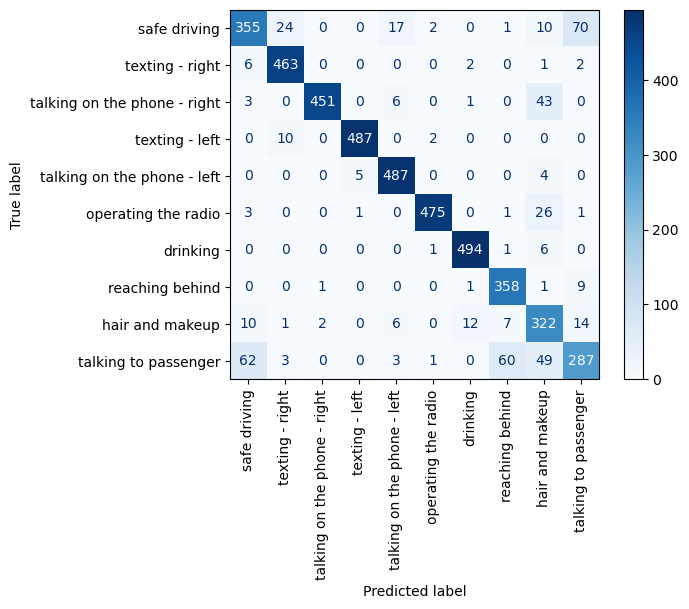

In [28]:
unpack_results(vgg16_results, weighted_predictor)

In [55]:
# Testing results if talking to passenger was omitted
y, t, _, _ = vgg16_results

y = np.array(y)
t = np.array(t).flatten()

y = np.where(y == 9, 0, y)
t = np.where(t == 9, 0, t)

unpack_results((y, t, vgg16_results[2], vgg16_results[3]), weighted_predictor, confusion_matrix_labels=list(config['dataset']['class_mapping'].values())[:-1])

Average inference time 0.002974565177198651, which is 336 fps
Accuracy of all predictions 0.9231263383297644
Accuracy of weighted predictor 0.8603304012014589
F1 score of all predictions 0.9238563887635041
Precision score of all predictions 0.9194326579959454
Recall score of all predictions 0.9332037804627475


# Gradcam

In [125]:
# Global variables to store gradients and activations
gradients = None
activations = None

def backward_hook(module, inputs, outputs):
    global gradients
    gradients = outputs[0]  # Get the actual gradient tensor

def forward_hook(module, inputs, outputs):
    global activations
    activations = outputs
    
def grad_cam_test(model, img, layer, original_label=None, predicted_label=None, device='cpu'):
    """Function to generate Grad-CAM for a single image and a specified layer"""
    model.eval()
    img = img.to(device)

    # Register hooks on the specified layer
    layer.register_forward_hook(forward_hook)
    layer.register_full_backward_hook(backward_hook)

    # Forward pass
    with torch.enable_grad():
        img_input = img.unsqueeze(0).requires_grad_()
        prediction = model(img_input)
        prediction[:, prediction.argmax(1)].sum().backward()

        # Compute the heatmap
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        for i in range(activations.size()[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)

        # Plotting
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(T.functional.to_pil_image(img, mode='RGB'))
        title = 'Original Image'
        if original_label is not None:
            title += f'\nTrue Label: {original_label}'
        axs[0].set_title(title)
        axs[0].axis('off')

        # Plot heatmap with adjusted parameters or different colormap
        heatmap_detached = heatmap.cpu().detach().numpy()  # Detach and move to CPU
        axs[1].imshow(heatmap_detached, cmap='jet', interpolation='nearest')
        axs[1].set_title('Heatmap')
        axs[1].axis('off')

        # Plot Grad-CAM
        overlay = T.functional.to_pil_image(heatmap.detach(), mode='F').resize(img.shape[1:3], resample=PIL.Image.BICUBIC)
        cmap = colormaps['jet']
        overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
        axs[2].imshow(T.functional.to_pil_image(img, mode='RGB'))
        axs[2].imshow(overlay, alpha=0.4, interpolation='nearest')
        title = 'Grad-CAM'
        if predicted_label is not None:
            title += f'\nPredicted Label: {predicted_label}'
        axs[2].set_title(title)
        axs[2].axis('off')

        plt.show()
        
def run_gradcam(model, layer, test_dataloader, device, num_images=10):
    # set model to eval and device
    model = model.eval()
    model = model.to(device)
    layer = layer.to(device)
    
    # Assuming test_dataloader is your DataLoader instance
    random_data = []
    for imgs, labels in test_dataloader:
        random_data.extend(zip(imgs, labels))
        if len(random_data) >= num_images:
            break
        
    # Now random_data contains at least num_images (image, label) pairs
    # We select num_images pairs randomly
    selected_data = random.sample(random_data, num_images)
    
    # Apply grad_cam_test on each of these images
    for img, original_label in selected_data:
        img, original_label = img.to(device), original_label.to(device)
        img_input = img.unsqueeze(0)
        
        with torch.no_grad():
            prediction = model(img_input.to(device))
        predicted_label = prediction.argmax(1).item()  # Assuming single output label
    
        # Convert labels to actual names if necessary, e.g., using a label map
        original_label_name = config['dataset']['class_mapping'][f'c{original_label}']  # Replace label_map with your label mapping
        predicted_label_name = config['dataset']['class_mapping'][f'c{predicted_label}'] # Replace label_map with your label mapping
    
        grad_cam_test(model, img, layer, original_label_name, predicted_label_name, device)
    

### Testing on random images in test loader

In [167]:
test_dataloader, test_data = prepare_data(img_size='L_SQUARED', shuffle=True)

In [205]:
layer = efficientb1.bn2 #efficientb1.blocks[-1][-1].conv_pwl

In [204]:
efficientb1.bn2

BatchNormAct2d(
  1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
  (drop): Identity()
  (act): SiLU(inplace=True)
)

In [215]:
efficientb1

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In [212]:
efficient.features[-1]

ConvBnAct(
  (conv): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (batch_norm): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): SiLU()
)

In [223]:
nn.Sequential(
    efficientb1.conv_head,
    efficientb1.bn2
)

Sequential(
  (0): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNormAct2d(
    1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
)

In [222]:
efficientb1.conv_head# , efficientb1.bn2

Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)

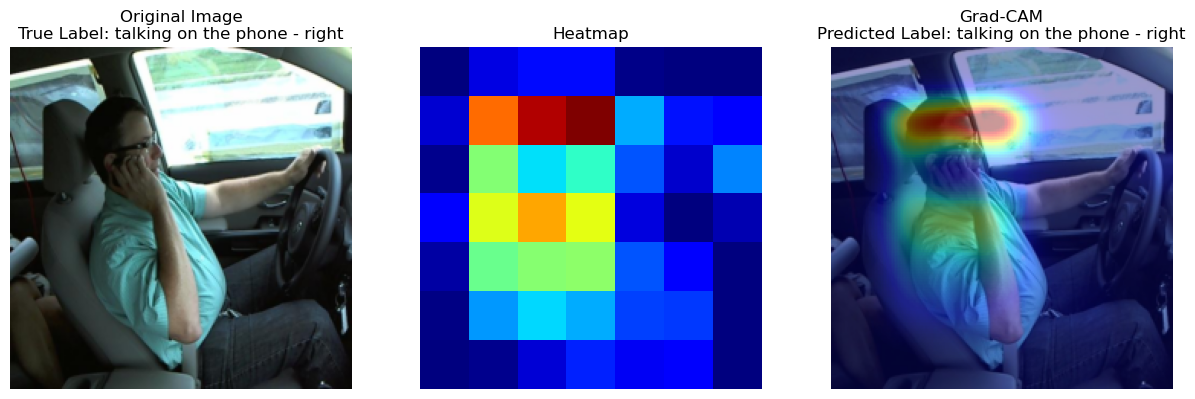

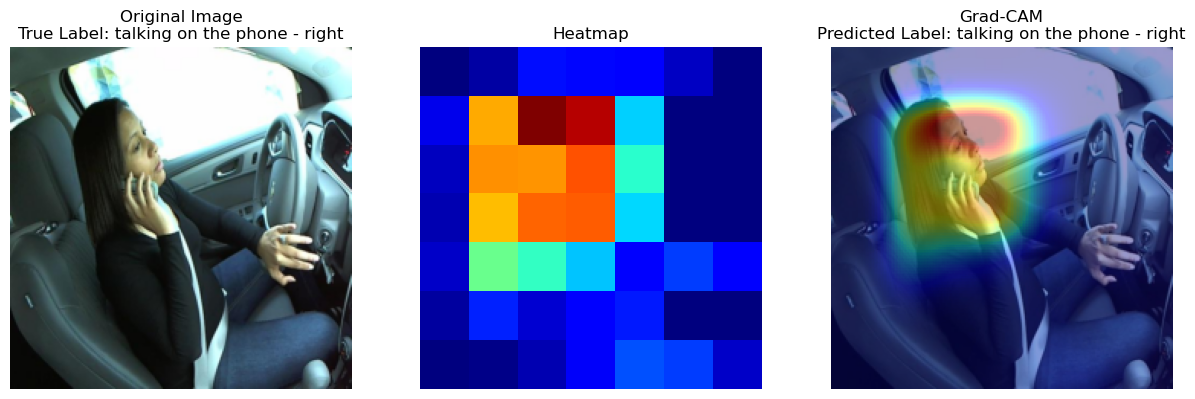

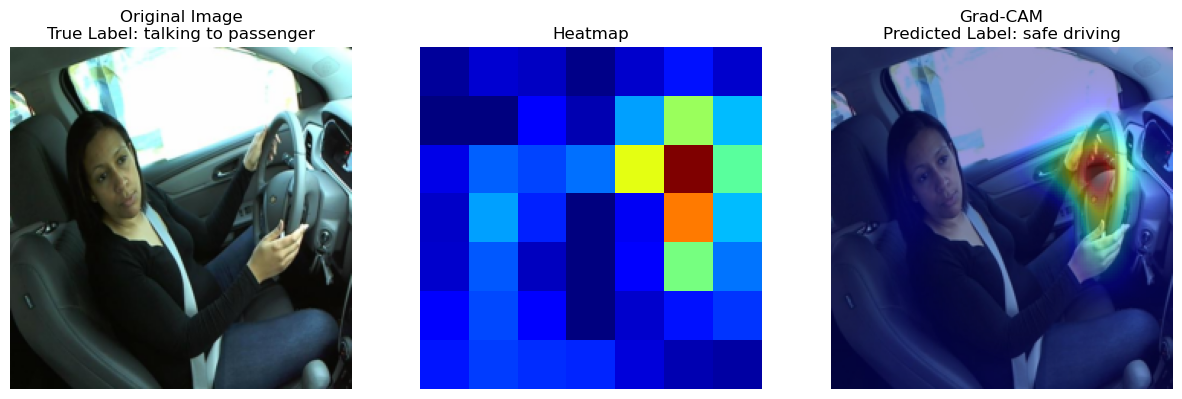

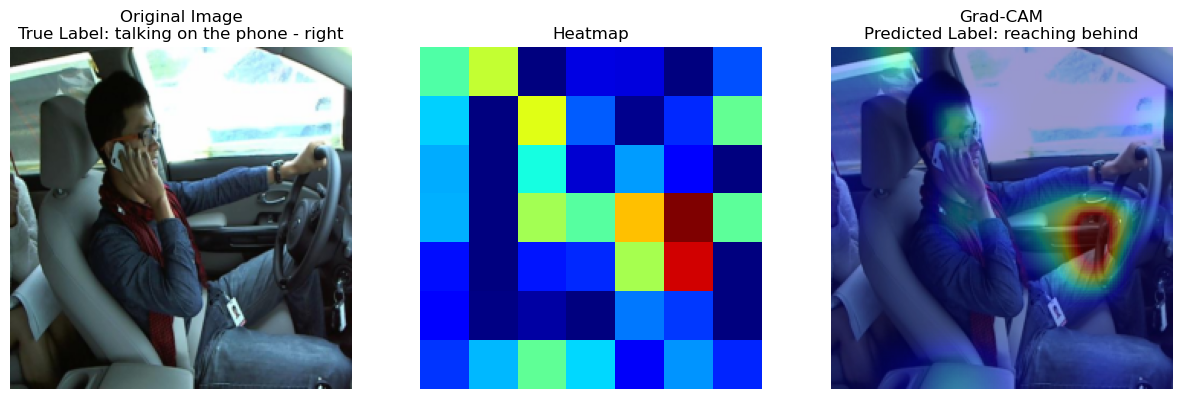

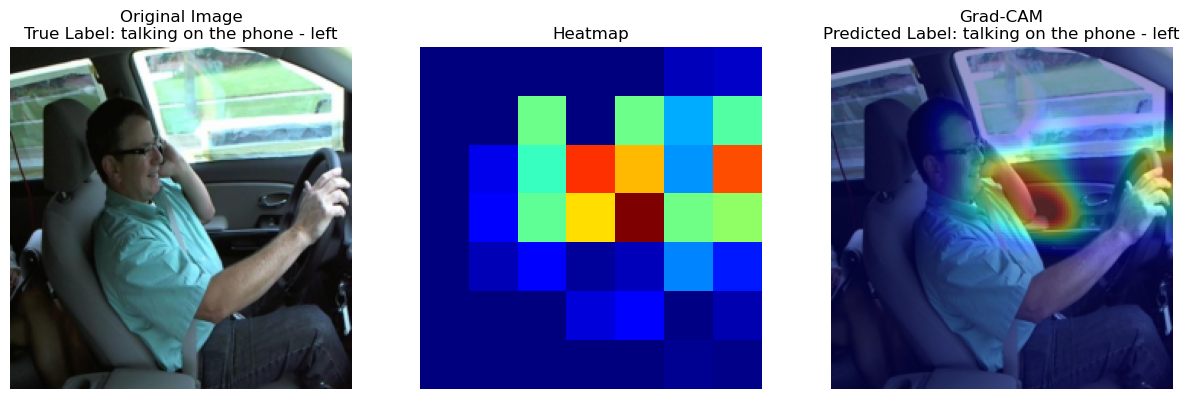

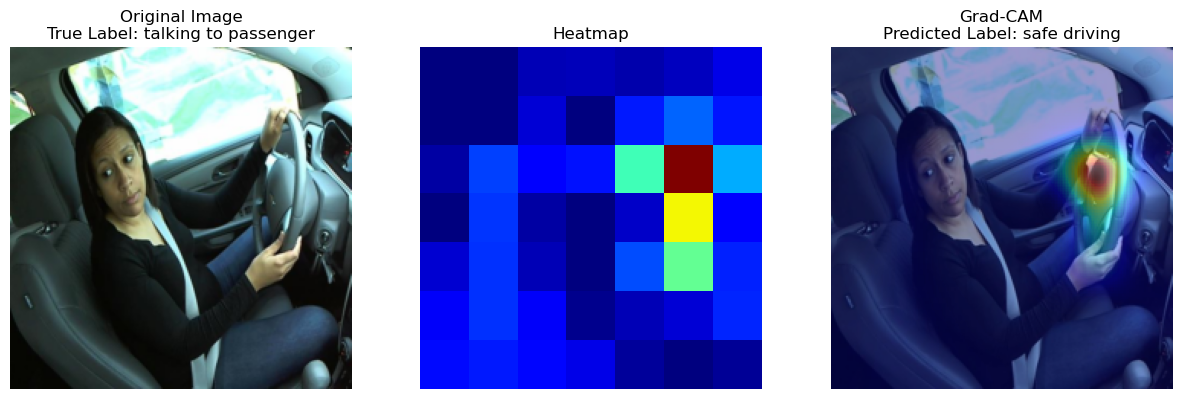

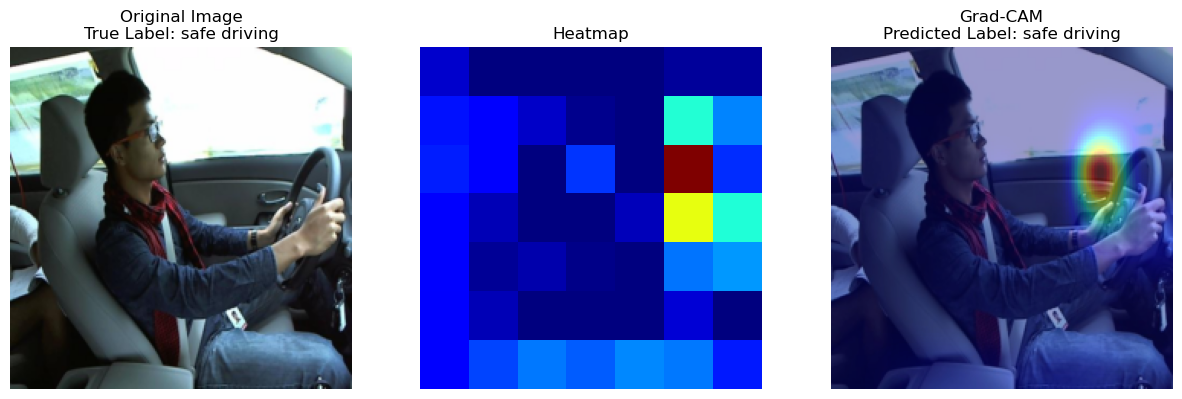

In [224]:
# Assuming test_dataloader is your DataLoader instance
run_gradcam(efficient, nn.Sequential(
    efficientb1.conv_head,
    efficientb1.bn2
), test_dataloader, device, num_images=10)